<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "Unc5c"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/Level3-SubCellType/Unc5c/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


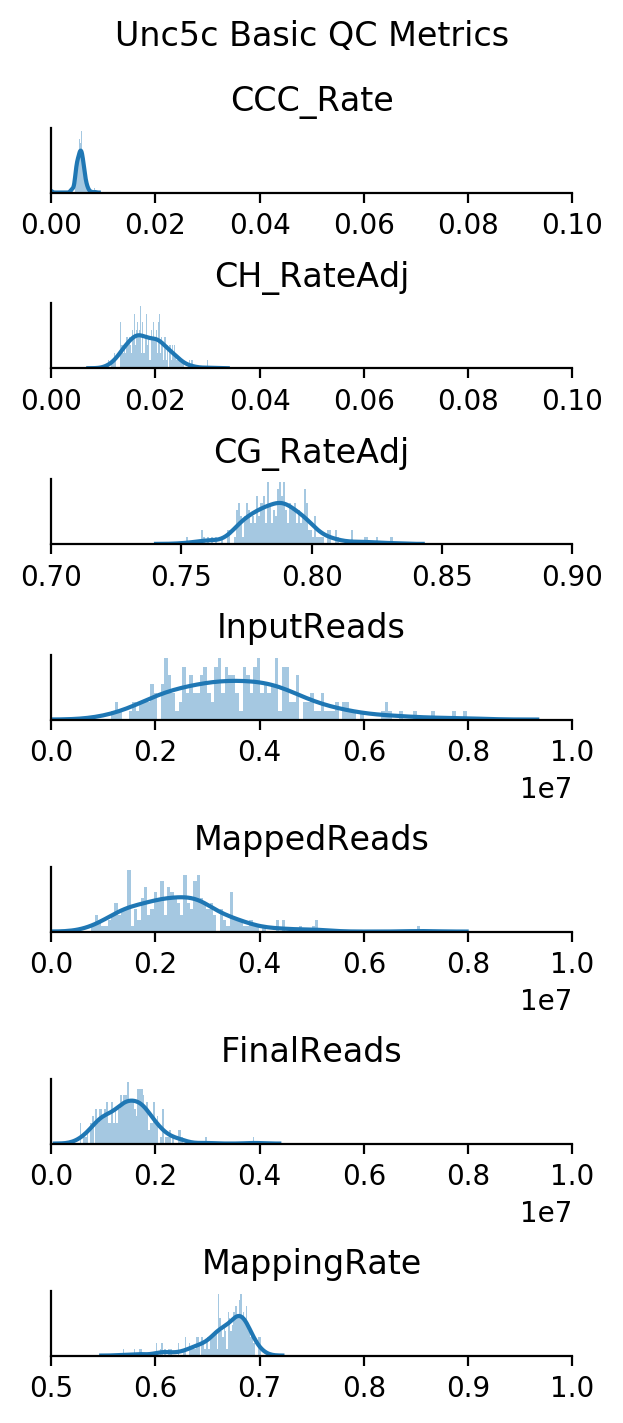

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

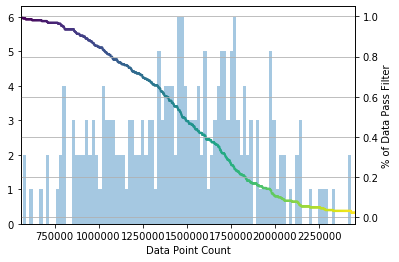

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 219/219 (100.0%)
CG_RateAdj passed 219/219 (100.0%)
CH_RateAdj passed 219/219 (100.0%)
FinalReads passed 219/219 (100.0%)
MappingRate passed 219/219 (100.0%)
Overall passed 219/219 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
171213 1
180104 1
180119 1
180130 2
180205 3
180206 2
180208 1
180212 2
180220 1
180222 2
180227 1
180306 2
180313 1
180320 4
180326 2
180329 1
180403 1
180410 1
180417 1
180419 2
180424 1
180430 1
180501 3
180514 1
180917 1
181008 2
181009 1
181022 2
181023 1
181204 1
181210 2
190108 1
190117 1
190122 1
190131 1
190205 1
190212 13
190214 35
190219 21
190305 22
190307 2
190625 9
190627 15
190711 31
190716 18


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 22 5.7%
ad002 40 10.4%
ad004 20 5.2%
ad006 28 7.3%
ad007 28 7.3%
ad008 31 8.1%
ad010 26 6.8%
ad012 24 6.2%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l1-umap_0,l1-umap_1,l1-tsne_0,l1-tsne_1,MajorType,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,PassFilter
cell,,,,,,,,,,,,,,,,,,,,,
10E_M_109,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.005839,0.772664,0.771329,0.019089,0.013327,796516.0,1890630,1203975.0,10E,...,-4.248928,17.333439,-7.310064,45.311789,Unc5c,-30.295033,-11.153941,28.020417,-50.321330,True
10E_M_1526,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.004817,0.764397,0.763256,0.016351,0.011589,1078279.0,2741252,1794215.0,10E,...,-3.753995,17.666348,-8.174585,45.083965,Unc5c,-29.880449,-11.409056,27.469891,-48.594062,True
10E_M_158,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.005242,0.769475,0.768260,0.019511,0.014343,1926889.0,5310942,3521039.0,10E,...,-4.354726,17.173820,-6.745754,44.878221,Unc5c,-30.442921,-11.374076,27.990793,-50.948852,True
10E_M_1642,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.005162,0.779014,0.777867,0.021632,0.016556,2522233.0,7971538,5047061.0,10E,...,-4.602761,17.418255,-6.628316,45.112016,Unc5c,-30.595158,-11.872423,27.495115,-52.162254,True
10E_M_1655,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.005364,0.791033,0.789906,0.022530,0.017258,1658614.0,5762620,3622653.0,10E,...,-4.179933,17.554628,-7.007049,45.318056,Unc5c,-30.020283,-11.832796,25.590081,-53.528557,True
10E_M_1676,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.006568,0.796651,0.795307,0.029851,0.023437,2050501.0,5963066,3896463.0,10E,...,-4.428669,17.088991,-6.769602,44.797701,Unc5c,-29.709118,-11.735326,25.300066,-50.978605,True
10E_M_1954,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.006390,0.782241,0.780841,0.027949,0.021697,1869281.0,5319594,3486308.0,10E,...,-4.347658,17.264400,-6.790746,44.919803,Unc5c,-29.853956,-11.978023,25.322440,-51.391024,True
10E_M_2279,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.006222,0.797966,0.796701,0.028502,0.022419,2431746.0,7761928,5110266.0,10E,...,-4.410150,17.123331,-6.747070,44.791250,Unc5c,-29.610464,-11.690665,25.445770,-50.302147,True
10E_M_2625,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.006439,0.780872,0.779451,0.028154,0.021856,1993249.0,5507290,3550533.0,10E,...,-4.462500,17.193087,-6.696806,44.851520,Unc5c,-30.092548,-11.728392,26.117890,-50.887701,True
